<a href="https://colab.research.google.com/github/azurerose-b21cap0299/healthcare-app/blob/main/Machine%20Learning/Food_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tensorflow Version**

In [3]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [4]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

chmod: cannot access 'kaggle.json': No such file or directory


**Load Data**

In [5]:
!kaggle datasets download moltean/fruits

 99% 755M/760M [00:14<00:00, 57.5MB/s]
100% 760M/760M [00:14<00:00, 56.2MB/s]


In [6]:
import os
import zipfile

local_zip = "fruits.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [7]:
!mkdir /tmp/fruits
!mkdir /tmp/fruits/training
!mkdir /tmp/fruits/training/kiwi
!mkdir /tmp/fruits/training/lemon
!mkdir /tmp/fruits/training/orange
!mkdir /tmp/fruits/test
!mkdir /tmp/fruits/test/kiwi
!mkdir /tmp/fruits/test/lemon
!mkdir /tmp/fruits/test/orange

In [8]:
!cp /tmp/fruits-360/Training/Kiwi/* /tmp/fruits/training/kiwi
!cp /tmp/fruits-360/Training/Lemon/* /tmp/fruits/training/lemon
!cp /tmp/fruits-360/Training/Orange/* /tmp/fruits/training/orange
!cp /tmp/fruits-360/Test/Kiwi/* /tmp/fruits/test/kiwi
!cp /tmp/fruits-360/Test/Lemon/* /tmp/fruits/test/lemon
!cp /tmp/fruits-360/Test/Orange/* /tmp/fruits/test/orange

In [9]:
train_dir = "/tmp/fruits/training"
test_dir = "/tmp/fruits/test"
kiwi_train_dir = train_dir+"/kiwi"
kiwi_test_dir = test_dir+"/kiwi"
lemon_train_dir = train_dir+"/lemon"
lemon_test_dir = test_dir+"/lemon"
orange_train_dir = train_dir+"/orange"
orange_test_dir = test_dir+"/orange"

**Data Visualization**

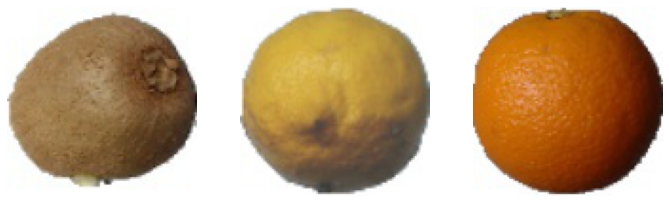

In [10]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sample_kiwi = random.choice(os.listdir(kiwi_train_dir))
sample_lemon = random.choice(os.listdir(lemon_train_dir))
sample_orange = random.choice(os.listdir(orange_train_dir))
sample = [os.path.join(kiwi_train_dir,sample_kiwi)]+[os.path.join(lemon_train_dir,sample_lemon)]+[os.path.join(orange_train_dir,sample_orange)]

fig = plt.gcf()
fig.set_size_inches(16, 16)
for i, img_path in enumerate(sample):
  plt.subplot(4,4,i+1)
  plt.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

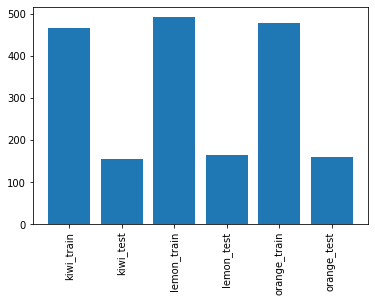

test size of all images:
Kiwi: 0.25 Lemon: 0.25 Orange: 0.25


In [11]:
import matplotlib.pyplot as plt

kiwi_train = len(os.listdir(kiwi_train_dir))
kiwi_test = len(os.listdir(kiwi_test_dir))
lemon_train = len(os.listdir(lemon_train_dir))
lemon_test = len(os.listdir(lemon_test_dir))
orange_train = len(os.listdir(orange_train_dir))
orange_test = len(os.listdir(orange_test_dir))

file,fn = (kiwi_train,kiwi_test,lemon_train,lemon_test,orange_train,orange_test),("kiwi_train","kiwi_test","lemon_train","lemon_test","orange_train","orange_test")
x_coord = [x for x in range(len(fn))]
plt.bar(x_coord, file, tick_label=fn)
plt.xticks(rotation=90)
plt.show()

print("test size of all images:")
print('Kiwi: %.2f'%(kiwi_test/(kiwi_train+kiwi_test)), 'Lemon: %.2f'%(orange_test/(orange_train+orange_test)),'Orange: %.2f'%(lemon_test/(lemon_train+lemon_test)))

**Data Preprocessing**

In [12]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

#Define Callback when loss less than 0.01
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99 and logs.get('val_accuracy')>0.99):
      self.model.stop_training = True

callbacks = myCallback()

#Define Training Data using Image Augmentation
TRAINING_DIR = train_dir
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      brightness_range=[1.0,2],
      horizontal_flip=True,
      fill_mode='nearest')

train_gen = train_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(100,100),
	class_mode='categorical',
  batch_size=128
)

#Define Validation Data
VALIDATION_DIR = test_dir
val_datagen = ImageDataGenerator(rescale = 1./255)

val_gen = val_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(100,100),
	class_mode='categorical',
  batch_size=32
)

Found 1437 images belonging to 3 classes.
Found 480 images belonging to 3 classes.


**Define and Train the Model**

In [13]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dropout,Dense
#Define Model Sequential Using CNN
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])
epochs=10
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_gen, epochs=epochs, validation_data = val_gen, callbacks=[callbacks])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         1

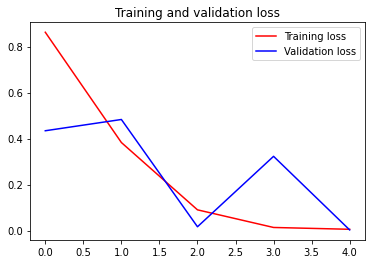

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Predict Image**

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from keras_preprocessing.image import load_img, img_to_array

def process(image):
  image = load_img(image, target_size=(100,100))
  img = img_to_array(image)
  img = np.expand_dims(img, axis=0)
  img = np.vstack([img])
  return img, image

def classify(classes):
  if classes[0][0]==1:
    return "Kiwi"
  elif classes[0][1]==1:
    return "Lemon"
  elif classes[0][2]==1:
    return "Orange"
  return "None"

def visualize(image):
  plt.imshow(image)
  plt.axis('off')
  plt.show()

Saving 0_100.jpg to 0_100.jpg
Saving 2.jpg to 2.jpg
Saving 05795a16b647118ffb6629390e995adb.jpg to 05795a16b647118ffb6629390e995adb.jpg
Saving 266556.jpg to 266556.jpg
Saving 319558b3-3fe2-43e1-a43f-bbbb81152de3.jpg to 319558b3-3fe2-43e1-a43f-bbbb81152de3.jpg
Saving 000375185.webp to 000375185.webp
Saving 100080576_f52e8ee070_n.jpg to 100080576_f52e8ee070_n.jpg
Saving avocado-pexels-thought-catalog-public-domain-.jpg to avocado-pexels-thought-catalog-public-domain-.jpg
Saving d.jpg to d.jpg
Saving download.jpg to download.jpg
Saving f.jpg to f.jpg
Saving GUEST_6d9d5f9f-7206-49c4-a381-6ba5a0c08504.jpg to GUEST_6d9d5f9f-7206-49c4-a381-6ba5a0c08504.jpg
Saving images (1).jpg to images (1).jpg
Saving images.jpg to images.jpg
Saving k.jpg to k.jpg
Saving Lemon.jpg to Lemon.jpg
Saving lemon_hd.jpg to lemon_hd.jpg


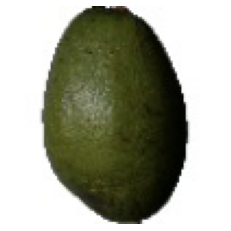

0_100.jpg is Lemon


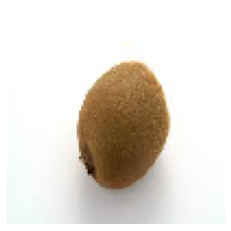

2.jpg is Kiwi


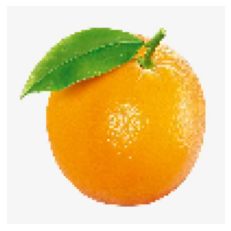

05795a16b647118ffb6629390e995adb.jpg is Orange


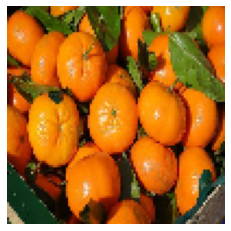

266556.jpg is Orange


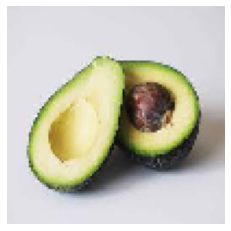

319558b3-3fe2-43e1-a43f-bbbb81152de3.jpg is Kiwi


000375185.webp is Lemon


100080576_f52e8ee070_n.jpg is Orange


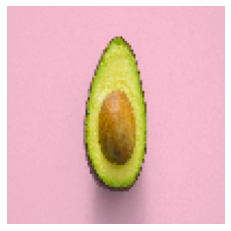

avocado-pexels-thought-catalog-public-domain-.jpg is Lemon


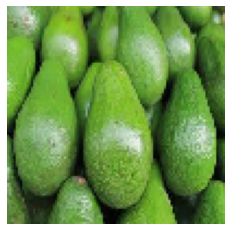

d.jpg is Lemon


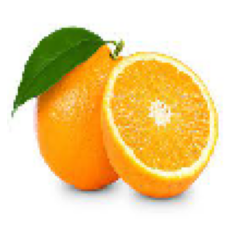

download.jpg is Orange


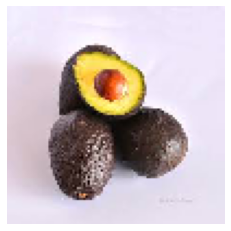

f.jpg is Kiwi


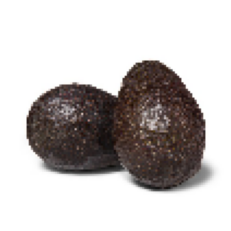

GUEST_6d9d5f9f-7206-49c4-a381-6ba5a0c08504.jpg is Kiwi


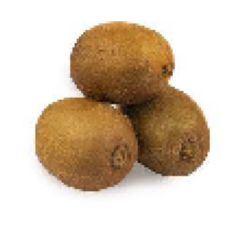

images (1).jpg is Kiwi


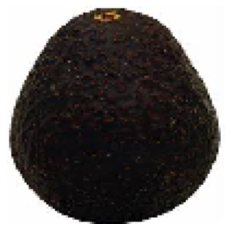

images.jpg is Kiwi


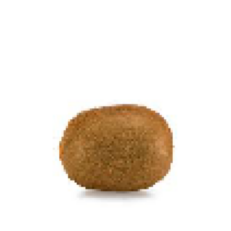

k.jpg is Kiwi


Lemon.jpg is Lemon


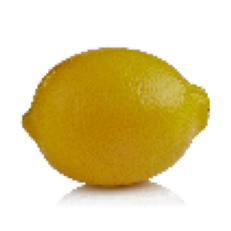

lemon_hd.jpg is Lemon


In [16]:
from google.colab import files

uploaded = files.upload()
for file in uploaded.keys():
  img, image = process(file)
  classes = model.predict(img)
  visualize(image)
  print(file+" is "+classify(classes))

**Save the model**

In [17]:
import time
import tensorflow as tf

saved_model_path = "/tmp/saved_model/{}".format(int(time.time()))
tf.saved_model.save(model, saved_model_path)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /tmp/saved_model/1623211422/assets


**Convert the Model to TFLite**

In [18]:
import tensorflow as tf
tflite_model_file = 'converted_model.tflite'

In [20]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
tflite_model = converter.convert()

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [21]:
class_names=['kiwi', 'lemon', 'orange']
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

**Predict Image with Interpreter**

In [22]:
#Load the tflite model
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()

#Create Interpreter
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

#Create Input and Output Index
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from keras_preprocessing.image import load_img, img_to_array
from google.colab import files

uploaded = files.upload()
for file in uploaded.keys():
  img, image = process(file)
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  classes = interpreter.get_tensor(output_index)
  visualize(image)
  print(file+" is "+classify(classes))

**Convert the Model to Json Format**

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter \
  --input_format=keras_saved_model \
  /tmp/saved_model/1623073304 \
  /tmp/foodclassification